<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# Components for modeling overland flow erosion 

*(G.E. Tucker, July 2021)*

There are two related components that calculate erosion resulting from surface-water flow, a.k.a. overland flow: `DepthSlopeProductErosion` and `DetachmentLtdErosion`. They were originally created by Jordan Adams to work with the `OverlandFlow` component, which solves for water depth across the terrain. They are similar to the `StreamPowerEroder` and `FastscapeEroder` components in that they calculate erosion resulting from water flow across a topographic surface, but whereas these components require a flow-routing algorithm to create a list of node "receivers", the `DepthSlopeProductErosion` and `DetachmentLtdErosion` components only require a user-identified slope field together with an at-node depth or discharge field (respectively).

## `DepthSlopeProductErosion`

This component represents the rate of erosion, $E$, by surface water flow as:

$$E = k_e (\tau^a - \tau_c^a)$$

where $k_e$ is an erodibility coefficient (with dimensions of velocity per stress$^a$), $\tau$ is bed shear stress, $\tau_c$ is a minimum bed shear stress for any erosion to occur, and $a$ is a parameter that is commonly treated as unity.

For steady, uniform flow, 

$$\tau = \rho g H S$$,

with $\rho$ being fluid density, $g$ gravitational acceleration, $H$ local water depth, and $S$ the (postive-downhill) slope gradient (an approximation of the sine of the slope angle).

The component uses a user-supplied slope field (at nodes) together with the water-depth field `surface_water__depth` to calculate $\tau$, and then the above equation to calculate $E$. The component will then modify the `topographic__elevation` field accordingly. If the user wishes to apply material uplift relative to baselevel, an `uplift_rate` parameter can be passed on initialization.

Here are the header and constructor docstrings:

In [1]:
from landlab.components import DepthSlopeProductErosion

print(DepthSlopeProductErosion.__doc__)

Calculate erosion rate as a function of the depth-slope product.

    ..math::

        E = k_e *(	au^a - 	au_c^a)

    :math:`E = ` erosion rate (length per time)
    k_e = erodibility coefficient
    Tau = bed shear stress
        = density of fluid (rho) * gravitational acceleration (g) * water depths (h) * slopes (S)
    Tau_crit = critical shear stress
    a = positive exponent

    Note this equation was presented in Tucker, G.T., 2004, Drainage basin
    sensitivityto tectonic and climatic forcing: Implications of a stochastic
    model for the role of entrainment and erosion thresholds,
    Earth Surface Processes and Landforms.

    More generalized than other erosion components, as it doesn't require the
    upstream node order, links to flow receiver and flow receiver fields. Instead,
    takes in the water depth and slope fields on NODES calculated by the
    OverlandFlow class and erodes the landscape in response to the hydrograph
    generted by that method.

    As of ri

In [2]:
print(DepthSlopeProductErosion.__init__.__doc__)

Calculate detachment limited erosion rate on nodes using the shear
        stress equation, solved using the depth slope product.

        Landlab component that generalizes the detachment limited erosion
        equation, primarily to be coupled to the the Landlab OverlandFlow
        component.

        This component adjusts topographic elevation and is contained in the
        landlab.components.detachment_ltd_erosion folder.

        Parameters
        ----------
        grid : RasterModelGrid
            A landlab grid.
        k_e : float
            Erodibility parameter, (m^(1+a_exp)*s^(2*a_exp-1)/kg^a_exp)
        fluid_density : float, optional
            Density of fluid, default set to water density of 1000 kg / m^3
        g : float, optional
            Acceleration due to gravity (m/s^2).
        a_exp : float, optional
            exponent on shear stress, positive, unitless
        tau_crit : float, optional
            threshold for sediment movement, (kg/m/s^2)
   

### Example

In this example, we load the topography of a small drainage basin, calculate a water-depth field by running overland flow over the topography using the `KinwaveImplicitOverlandFlow` component, and then calculating the resulting erosion.

Note that in order to accomplish this, we need to identify which variable we wish to use for slope gradient. This is not quite as simple as it may sound. An easy way to define slope is as the slope between two adjacent grid nodes. But using this approach means that slope is defined on the grid *links* rathter than *nodes*. To calculate slope magnitude at *nodes*, we'll define a little function below that uses Landlab's `calc_grid_at_link` method to calculate gradients at grid links, then use the `map_link_vector_components_to_node` method to calculate the $x$ and $y$ vector components at each node. With that in hand, we just use the Pythagorean theorem to find the slope magnitude from its vector components.

First, though, some imports we'll need:

In [5]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import imshow_grid
from landlab.components.overland_flow import KinwaveImplicitOverlandFlow
from landlab.grid.mappers import map_link_vector_components_to_node
from landlab.io import read_esri_ascii

In [19]:
def slope_magnitude_at_node(grid, elev):
    grad_at_link = grid.calc_grad_at_link(elev)
    grad_at_link[grid.status_at_link != grid.BC_LINK_IS_ACTIVE] = 0.0
    slp_x, slp_y = map_link_vector_components_to_node(grid, grad_at_link)
    slp_mag = (slp_x*slp_x + slp_y*slp_y)**0.5
    return slp_mag, slp_x, slp_y

Next, define some parameters we'll need:

In [6]:
# Process parameters
n = 0.1  # roughness coefficient, (s/m^(1/3))
dep_exp = 5.0 / 3.0 # depth exponent
R = 72.0 # runoff rate, mm/hr

# Run-control parameters
rain_duration = 240.0 # duration of rainfall, s
run_time = 480.0  # duration of run, s
dt = 10.0 # time-step size, s
dem_filename = '../hugo_site.asc'

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge and time
time_since_storm_start = np.arange(0.0, dt * (2 * num_steps + 1), dt)
discharge = np.zeros(2 * num_steps + 1)

Read an example digital elevation model (DEM) into a Landlab grid and set up the boundaries so that water can only exit out the right edge, representing the watershed outlet.

In [7]:
# Read the DEM file as a grid with a 'topographic__elevation' field
(grid, elev) = read_esri_ascii(dem_filename, name='topographic__elevation')

# Configure the boundaries: valid right-edge nodes will be open; 
# all NODATA (= -9999) nodes will be closed.
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_FIXED_VALUE
grid.status_at_node[np.isclose(elev, -9999.)] = grid.BC_NODE_IS_CLOSED

Now we'll calculate the slope vector components and magnitude, and plot the vectors as quivers on top of a shaded image of the topography:

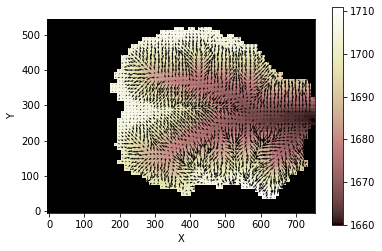

In [20]:
slp_mag, slp_x, slp_y = slope_magnitude_at_node(grid, elev)
imshow_grid(grid, elev)
plt.quiver(grid.x_of_node, grid.y_of_node, slp_x, slp_y)

Let's take a look at the slope magnitudes:

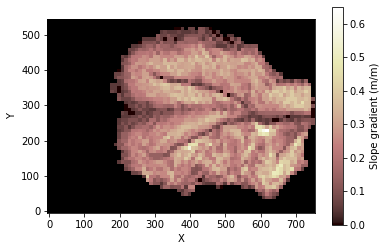

In [21]:
imshow_grid(grid, slp_mag, colorbar_label='Slope gradient (m/m)')

Now we're ready to instantiate a `KinwaveImplicitOverlandFlow` component, with a specified runoff rate and roughness:

In [9]:
# Instantiate the component
olflow = KinwaveImplicitOverlandFlow(grid,
                                     runoff_rate=R, 
                                     roughness=n,
                                     depth_exp=dep_exp
                                    )

And also instantiate a `DepthSlopeProductErosion` component:

['topographic__elevation',
 'surface_water__depth',
 'surface_water_inflow__discharge',
 'water__unit_flux_in',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'flow__receiver_proportions',
 'topographic__steepest_slope']

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>